# **Laboratory Task 6**

Instruction: Convert the following CNN architecture diagram into a PyTorch CNN Architecture.

![Alt Text](../Laboratories/assets/image.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean/std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):  # You can change num_classes
        super(CNN, self).__init__()
        
        # --- Convolutional Block 1 ---
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, 2, 1)
        
        # --- Convolutional Block 2 ---
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2, 0)
        
        # --- Dropout and Flatten ---
        self.dropout = nn.Dropout(p=0.2)
        
        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(256 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, num_classes)
        
    def forward(self, x):
        # Convolution Block 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Convolution Block 2
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Flatten and Dropout
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)  # <-- Use LogSoftmax for NLLLoss
        
        return x

In [4]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=12544, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


In [5]:
criterion = criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# if your device has cuda enabled gpu, you can use it to accelerate the training process.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = model.to(device)

cpu


In [7]:
import time
import os

def set_seed(seed):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Create model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

epochs = 5
start_time = time.time()
best_acc = 0.0

train_correct = []
train_losses = []
train_accs = []

val_correct = []
val_losses = []
val_accs = []

batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    model.train()
    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {e+1}/{epochs}"):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1] # prediction vector
        train_corr += (train_pred_vec == y_train).sum()

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())

    train_epoch_acc = train_corr.item() / len(train_dataset)
    train_accs.append(train_epoch_acc)
    
    print(f"\nEpoch {e+1} training accuracy: {train_epoch_acc*100:.2f}%")

    model.eval()
    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(test_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())
            
        val_epoch_acc = val_corr.item() / len(test_dataset)
        val_accs.append(val_epoch_acc)
        
        print(f"Epoch {e+1} validation accuracy: {val_epoch_acc*100:.2f}%")
            
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), f"model/best_{model._get_name()}.pth")
            print(f"\tNew best model saved! | accuracy: {best_acc*100:.2f}%")

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 1/5: 100%|██████████| 938/938 [05:59<00:00,  2.61it/s]



Epoch 1 training accuracy: 93.52%
Epoch 1 validation accuracy: 97.80%
	New best model saved! | accuracy: 97.80%


Epoch 2/5: 100%|██████████| 938/938 [05:23<00:00,  2.90it/s]



Epoch 2 training accuracy: 98.24%
Epoch 2 validation accuracy: 98.87%
	New best model saved! | accuracy: 98.87%


Epoch 3/5: 100%|██████████| 938/938 [05:49<00:00,  2.68it/s]



Epoch 3 training accuracy: 98.86%
Epoch 3 validation accuracy: 98.74%


Epoch 4/5: 100%|██████████| 938/938 [05:57<00:00,  2.63it/s]



Epoch 4 training accuracy: 99.09%
Epoch 4 validation accuracy: 99.14%
	New best model saved! | accuracy: 99.14%


Epoch 5/5: 100%|██████████| 938/938 [05:40<00:00,  2.76it/s]



Epoch 5 training accuracy: 99.33%
Epoch 5 validation accuracy: 99.12%

Duration: 1795 seconds


In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.12%


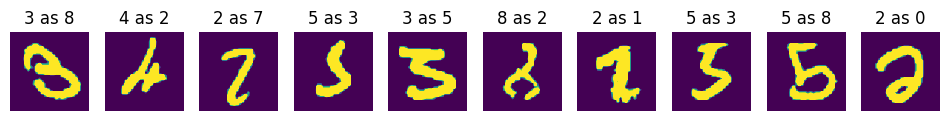

In [9]:
# Get all predictions and true labels for the test set
all_preds = []
all_targets = []
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Find indices where prediction is wrong
misses = np.where(all_preds != all_targets)[0]

# Prepare wrong predictions and true labels
wrong = [all_preds[i] for i in misses[:10]]
missed_label = [all_targets[i] for i in misses[:10]]
missed_images = [test_loader.dataset[j][0] for j in misses[:10]]

fig, axs = plt.subplots(1, len(missed_images), figsize=(12, 2))

for c, img in enumerate(missed_images):
    axs[c].imshow(img.view(28, 28), vmin=0, vmax=1)
    axs[c].axis('off')
    axs[c].set_title(f"{missed_label[c]} as {wrong[c]}")
plt.show()

## **Summary**

We trained a Convolutional Neural Network (CNN) on the MNIST handwritten digit dataset using PyTorch. The model has several convolutional layers with ReLU activations, two pooling layers, a dropout layer to reduce overfitting, and three fully connected layers that output the 10 digit classes.

The model was trained for **5 epochs** using the **Adam optimizer (lr = 0.001)** and **Negative Log-Likelihood Loss (NLLLoss)**.
It reached very high performance:

* **Training Accuracy:** 99.09%
* **Validation Accuracy:** 99.14%
* **Best Model Accuracy:** 99.12%

The classification report shows almost perfect precision, recall, and F1-scores for all digits, all around **0.99**, meaning the model predicts most digits correctly.



**Why We Used NLLLoss Instead of CrossEntropyLoss**

At first, we tried using **CrossEntropyLoss**, but the accuracy was only about **9%**. This happened because our model’s last layer already uses **`F.log_softmax()`**, which turns outputs into log probabilities.

`CrossEntropyLoss` already includes both **softmax and log** steps inside it. So when we used it together with `log_softmax`, the model applied these operations **twice**, which confused the training process. This caused the model to perform almost like random guessing (around 10% accuracy for 10 classes).

https://colab.research.google.com/drive/13ar2OWgtgLpuUNeYnhmco05-8h1mjZ3-

By switching to **`NLLLoss`**, which correctly works with log probabilities, the model learned properly and quickly reached over **99% accuracy**.



**Conclusion**

The CNN worked very well on the MNIST dataset, showing that it can accurately recognize handwritten digits. The experiment also shows how important it is to **match the output layer and the loss function**. Using the right combination—`log_softmax` with `NLLLoss`—allowed the model to train correctly and reach excellent results.

Overall, the model is efficient, accurate, and generalizes well. Small improvements like adding **batch normalization** or **data augmentation** could make it even better.
